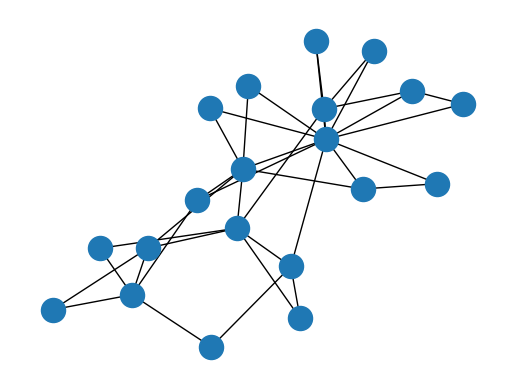

In [2]:
import numpy as np
import networkx as nx
import matplotlib.pyplot as plt

example_graph = nx.barabasi_albert_graph(20,2)
fig,axarr=plt.subplots()
nx.draw(example_graph)

# SIR model using graph theory
## The model

Using this model we want to analyze different vaccination approaches for an outbreak of disease in a population of 10 000 people. These models are generally based on the so called SIR model, which divides the population in three parts:
1. S or susceptible, are people who have not yet being infected by the disease
2. I or infected, are carriers of the disease who can pass it on
3. R or removed/recovered, are either the deceased or survivors of the disease,and also vaccinated.
Normally the dynamic is modelled using coupled first order differential equation, or growth equations, similiar to those found in other projects here. They genereally assume that one person can infect any other person, naively spoken. An alternative approach can be made by modeling the underlying population more "realistically" using sociograms, or graphs. For this we use the **Barabasi Albert model**. This model captures important statistical features of human interaction. The most noticable one being the fat tail in the distribution of the number of contacts or in the context of graph theory the degree of a node. In this approach we will create a graph with 10 000 nodes, each representing one member of the population. Each member or node is connected to another member of the population via an edge, which indicates, that these two members can meet each other and therefore infect each other.At every time step we therefore take a look at all the infected persons/nodes, here we have to assume that the infection can wear off and the infected person becomes a recovered, this will be modeled with a weight $\gamma$.  If this doesn't happen, with a weight $\beta$, we will take a look at each connected person or node and infect them with a given infection rate, describing the fact that both person meet and the infected person infects the susceptible one. This, in total , will then model an outbreak of a disease in the population.

In [3]:
def network_SIR(G_, t_end, I_init, beta, gamma,infection_rate, p_vaccinated,percentile=100, strat  = False):
    #checking whether the input is reasonable
    if p_vaccinated + I_init > 1.:
        raise ValueError('you cannot vaccinate and infect more people than there are I_init + p_vaccinated !<1')
    
    #initializing attributes to the nodes with respect to whether they are susceptible,
    #vaccinated or infected, here we have the randomly chosen method
    if strat==False:
        for i in range(G_.number_of_nodes()):
            random_number = np.random.uniform(0,1)
            if random_number < I_init :
                G_.nodes[i]['susceptible'] = 0 
                G_.nodes[i]['infected'] = 1
                G_.nodes[i]['recovered'] = 0
            if I_init < random_number < I_init + p_vaccinated :
                G_.nodes[i]['susceptible'] = 0 
                G_.nodes[i]['infected'] = 0
                G_.nodes[i]['recovered'] = 1
            if I_init + p_vaccinated < random_number < 1:
                G_.nodes[i]['susceptible'] = 1 
                G_.nodes[i]['infected'] = 0
                G_.nodes[i]['recovered'] = 0
                
    if strat == True: # here we vaccinate those nodes with higher degree preferentially
        
        lower_bound = np.percentile(list(dict(G.degree).values()), percentile)
        
        for i in range(G_.number_of_nodes()):
            random_number = np.random.uniform(0,1)
            if lower_bound < G_.degree[i]:
                G_.nodes[i]['susceptible'] = 0
                G_.nodes[i]['infected'] = 0
                G_.nodes[i]['recovered'] = 1
                
            if  G_.degree[i] < lower_bound and random_number < I_init :
                G_.nodes[i]['susceptible'] = 0
                G_.nodes[i]['infected'] = 1
                G_.nodes[i]['recovered'] = 0
                
            if  G_.degree[i] < lower_bound and random_number > I_init:
                G_.nodes[i]['susceptible'] = 1
                G_.nodes[i]['infected'] = 0
                G_.nodes[i]['recovered'] = 0
                
    #creating the lists to store the results
    S= []
    I= []
    R= []
    
    aux_susceptible =0
    aux_infected =0
    aux_recovered =0
    
    #saving the initial values
    for k in range(G_.number_of_nodes()):
        if G_.nodes[k]['susceptible']==1:
            aux_susceptible +=1
        if G_.nodes[k]['infected'] == 1:
            aux_infected +=1
        if G_.nodes[k]['recovered']==1:
            aux_recovered +=1
            
    S.append(aux_susceptible)
    I.append(aux_infected)
    R.append(aux_recovered)
    
    #iterating over all the nodes t_end times
    for i in range(t_end):
        
        aux_susceptible =0
        aux_infected =0
        aux_recovered =0
        
        infected_nodes = []
        #checking whether they can spread the infection or not
        for j in range(G_.number_of_nodes()):
            if G_.nodes[j]['recovered'] == 1:
                pass
            if G_.nodes[j]['susceptible'] ==1:
                pass
            if G_.nodes[j]['infected']==1: # we found an infected node, adding it to the list of infected nodes
                infected_nodes.append(j)
                
        for k in infected_nodes:
            random_number = np.random.uniform(0, beta+gamma)
            if random_number < gamma : 
                G_.nodes[k]['infected'] = 0
                G_.nodes[k]['recovered'] = 1
            else:
                for l in list(G_.neighbors(k)):
                    if G_.nodes[l]['infected']==1:
                        pass
                    if G_.nodes[l]['recovered']==1:
                        pass
                    if G_.nodes[l]['susceptible']==1:
                        random_number2 = np.random.uniform(0,1)
                        if random_number2<infection_rate:
                            G_.nodes[l]['susceptible']=0
                            G_.nodes[l]['infected']=1
                        else:
                            pass

                            
        for k in range(G_.number_of_nodes()):
            if G_.nodes[k]['susceptible']==1:
                aux_susceptible +=1
            if G_.nodes[k]['infected'] == 1:
                aux_infected +=1
            if G_.nodes[k]['recovered']==1:
                aux_recovered +=1
                
        S.append(aux_susceptible)
        I.append(aux_infected)
        R.append(aux_recovered)
    t = [i for i in range(t_end+1)]
    return t, S,I,R

 ## Vaccination strategies
Here we want to take a look at two different vaccination strategies. The first one or the naive approach, is to randomly vaccinated people regardless of their interactions. Here we aim for around $\approx 500$ vaccinated persons or persons who start in the category "R" so that they cannot transmit the disease. For the second approach, we will take a look at the top $5\%$ of the people with the most contacts, or nodes with the most edges. We will then vaccinate these persons and take a look at how the dynamics of the outbreak changes. In the last part we will then only vaccinate the top $1\%$ and compare the results using different metrics.

### The random vaccination strategy

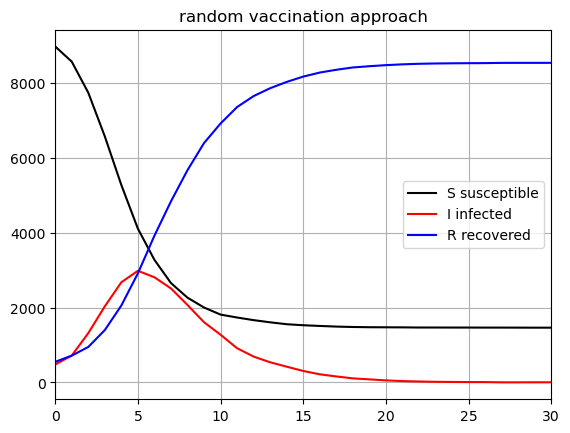

In [4]:
#same graph model used for the different vaccination strategies
G = nx.barabasi_albert_graph(10000,15)

# set of parameters used for all simulations besides percentile, which describes the percentile to be vaccinated
steps = 100
I_init = 0.05
infection_rate= 0.05
beta = 0.05
gamma = 0.025
p_vaccinated = 0.05
percentile=95

t_n, S_n,I_n,R_n = network_SIR(G,steps,I_init,beta,gamma,p_vaccinated,infection_rate,strat = False)

fig1, axarr1 = plt.subplots()
axarr1.plot(t_n, S_n , '-k' , label= 'S susceptible')
axarr1.plot(t_n, I_n , '-r' , label= 'I infected')
axarr1.plot(t_n, R_n , '-b' , label= 'R recovered')
axarr1.set_title('random vaccination approach')
axarr1.set_xlim([0,30])
axarr1.set_xticks(ticks=[0,5,10,15,20,25,30], labels=[0,5,10,15,20,25,30])
axarr1.legend(loc='center right')
axarr1.grid(True)


### Vaccinating the top 5 percent of nodes by degree

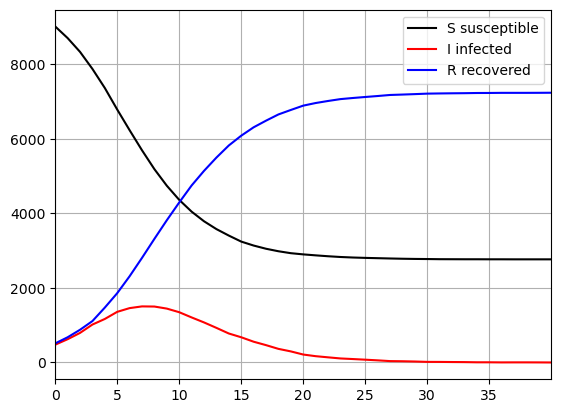

In [5]:
t_95,S_95,I_95,R_95 = network_SIR(G,steps,I_init,beta,gamma,p_vaccinated, infection_rate,percentile, strat = True)

fig2, axarr2 = plt.subplots()
axarr2.plot(t_95, S_95 , '-k' , label= 'S susceptible')
axarr2.plot(t_95, I_95 , '-r' , label= 'I infected')
axarr2.plot(t_95, R_95 , '-b' , label= 'R recovered')
axarr2.set_xlim([0,40])
axarr2.set_xticks(ticks=[0,5,10,15,20,25,30,35], labels=[0,5,10,15,20,25,30,35])
axarr2.legend()
axarr2.grid(True)

### Vaccinating the top 1 percent of nodes by degree

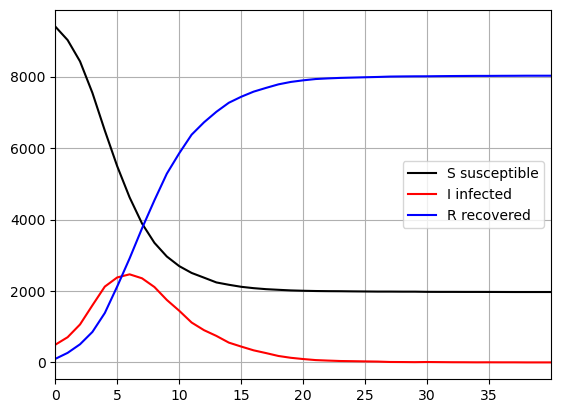

In [6]:
percentile = 99

t_99,S_99,I_99,R_99 = network_SIR(G,steps,I_init,beta,gamma,p_vaccinated, infection_rate,percentile, strat = True)

fig3, axarr3 = plt.subplots()
axarr3.plot(t_99, S_99 , '-k' , label= 'S susceptible')
axarr3.plot(t_99, I_99 , '-r' , label= 'I infected')
axarr3.plot(t_99, R_99 , '-b' , label= 'R recovered')
axarr3.set_xlim([0,40])
axarr3.set_xticks(ticks=[0,5,10,15,20,25,30,35], labels=[0,5,10,15,20,25,30,35])
axarr3.legend()
axarr3.grid(True)

# Analysis and Discussion
To analyze our results we want to take the perspective of puplic health officials. For these, three numbers are important, which we can draw from our graphs. <br></br>
First the maximal number of infected people at a given time, as it correlates with the maximal number of people hospitalised and given our experience with covid need a lot of potential care, especially if they have to be sent to the ICUs.
Second the time it takes to reach the peak, as it gives a time window, in which potentially critical equipment can be brought to the population, such as mask ventilators, additional personal, which we have been observing during the Covid outbreak, such as supplied aid within the EU. <br></br>
Third the number of susceptible people after the outbreak, aka the longterm value of $S$. This number can be interpreted in light of the original formulation of the SIR-model to understand, whether a new outbreak is possible within the population.

In [23]:
print("Maximal number of infected people for the different approaches \n")
print("random vaccination strategy:", max(I_n),"\n")
print("for vaccinating the top 5 percent:", max(I_95),"\n")
print("for vaccinating the top 1 percent", max(I_99), "\n")

Maximal number of infected people for the different approaches 

random vaccination strategy: 2981 

for vaccinating the top 5 percent: 1504 

for vaccinating the top 1 percent 2467 



For multiple test runs, we can observe the following in terms of the maximal number of infected people:
- The definetely worst appraoch to vaccinating the population is done via the random strategy
- with significant less vaccinations, it follows the top percent approach
- and the best outcome is created by vaccinating the top 5 percent which costs roughly the same amount of vaccination as the random approach.

As we can observe from the numbers, the highest peak can be observed for the random vaccination approach. This is obviously the most unsophisticated aprroach and it would have been surprising if this would have yielded the best results, given it doesn't account for the underlying structure of the population.
For the other approaches, which only differ quantitavely, we can observe that they offer better results, especially considering we can vaccinated the same amount of people and get half the maximum for the 5 percent approach. This is actually interesting as for the case of limited ressources, this allows to get the best results, with the same investment.

In [24]:
print("Maximum number of infected reached after \n")
print("random vaccination strategy:", I_n.index(max(I_n)),"weeks \n")
print("for vaccinating the top 5 percent:", I_95.index(max(I_95)),"weeks \n")
print("for vaccinating the top 1 percent:", I_99.index(max(I_99)),"weeks")

Maximum number of infected reached after 

random vaccination strategy: 5 weeks 

for vaccinating the top 5 percent: 7 weeks 

for vaccinating the top 1 percent: 6 weeks


For our test runs we observe again the same hierarchy of results. For convenience and to make the time scale somewhat realistic, we interpreted every timestep as one week.<br></br>
For our results we observed that vaccinating the top 5 percents grants another "2 weeks", before the maximal number of infected people is reached in comparison with the random approach, this, combined with the fact, that only half of the maximum is reached, may advocate for such a vaccination strategy further, as not only are half of the ressources of the public health sector bound to fight the disease, it as well has 2 weeks more time to prepare.


In [25]:
print("Maximum number of recovered \n")
print("random vaccination strategy:", R_n[len(R_n)-1],"\n")
print("for vaccinating the top 5 percent:", R_95[len(R_95)-1],"\n")
print("for vaccinating the top 1 percent:", R_99[len(R_99)-1],"\n")

Maximum number of recovered 

random vaccination strategy: 8540 

for vaccinating the top 5 percent: 7234 

for vaccinating the top 1 percent: 8029 



The total number of recovered with the already favourd top 5 percent strategy, followed by the 1 percent and then the random approach. This allows for the interpretation, that the top 5 percent strategy has the fewest deaths during the pandemic, as the number of recovered is proportial to the number of the deceased. This can further be highlighted by the fact, that the health system is under least amount of strain out of all the possible outcomes, which should further increase the survival rate for the infected individual. This is followed by the top 1 percent approach and with the highest amount recovered the random approach.<br></br>
We can further analyse these results by comparing it to the classical SIR model and its ODE form. Here we can define the following parameters:
- Basic reproduction number $R_0$
- and herd immunity
For this we take a look at a simplified version of the Basic reproduction number, since this model uses a network, this may be more convenient:
$R_0 = \left<deg(v)\right> p_{inf}$
With $\left<deg(v)\right>$ being the average degree and $p_{inf}$ the infection rate.

In [26]:
average_degree= sum(dict(G.degree()).values())/len(dict(G.degree()).values())

print("The average degree per node is:", average_degree)
print("This results in an average Basic production number of:", average_degree*infection_rate)

The average degree per node is: 29.955
This results in an average Basic production number of: 1.49775


Our infection therefore has an estimated basic reproduction number of around $\approx 1.5$. The threshold for herd immunity can be derived as: <br></br>
$\rho = \frac{N}{R_0}$
Which in our case takes on the value:<br></br>
$\rho \approx \frac{10 000}{1.5} = 6667$

Now we can compare this to our limits for the 'susceptible'. Here we see that for all the approaches tested a new outbreak of the disease, would not be happening. Or rather we would not observe a exponential growth as seen the first time. This is especially interesting, as we obviously favour an outcome that does prevent further epidemics.